<a href="https://colab.research.google.com/github/Jakubelo/ClothesClassifier/blob/main/CVClothesClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
! unzip 'gdrive/MyDrive/ClothesData/archive.zip'

In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter as SW

# EDA of data

In [26]:
df = pd.read_csv('/content/images.csv')
df.head(3)

,image,sender_id,label,kids
0,4285fab0-751a-4b74-8e9b-43af05deee22,124,Not sure,False
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,148,T-Shirt,False
2,00627a3f-0477-401c-95eb-92642cbe078d,94,Not sure,False


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5403 entries, 0 to 5402
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      5403 non-null   object
 1   sender_id  5403 non-null   int64 
 2   label      5403 non-null   object
 3   kids       5403 non-null   bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 132.0+ KB


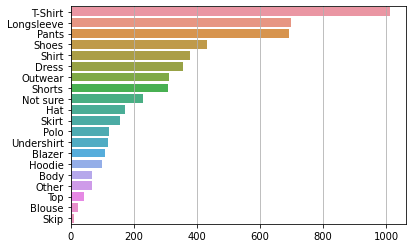

In [42]:
labels_stats = df.label.value_counts()
g = sns.barplot(x=labels_stats.values, y=labels_stats.index, orient='h')
plt.grid(axis='x')
plt.show()

The data is strongly imbalanced. Few of the categories are  not clear('Not sure' and "other" categories). The "Not sure" category has significant part of dataset, that might causing some confusion in learning

In [43]:
df.kids.value_counts()

False    4927
True      476
Name: kids, dtype: int64

The "kids" column can be applied as metadata, but the question is - Is it neccesary? - The "kids" label might introduce some explainability to the model when a input **is** or **not** "picture of kids clothes". Let's take a look for the Bernoulli distribution of each class with kids label.

In [75]:
def bernoulli(data, category:str):
  '''data = (categories_list, k_label)'''
  i = 0
  all_in_category = 0
  for row_index in range(len(data[0])):
    if data[0][row_index] == category and data[1][row_index]:
      i+=1
    
    all_in_category+=1

  return i/all_in_category

def bernoulli_list(data:pd.DataFrame,
                   categories_column:str,
                   k_labels:str):
  li_of_p = []
  categories = data[categories_column].unique()
  data_for_func = (data[categories_column].values, data[k_labels].values)
  for category in categories:
    li_of_p.append(
        bernoulli(data_for_func, category)
        )

  return pd.DataFrame({
      'p':li_of_p, 
      'category':categories
      }).sort_values(by='p', ascending=False).reset_index()


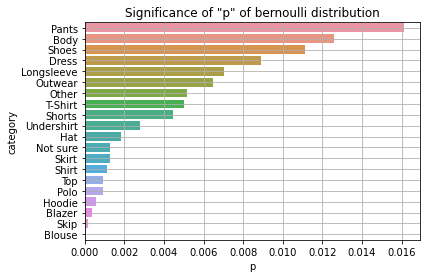

In [78]:
bernoulli_dist = bernoulli_list(df, 'label', 'kids')

sns.barplot(x=bernoulli_dist.p, y=bernoulli_dist.category, orient='h')
plt.title('Significance of "p" of bernoulli distribution')
plt.grid()
plt.show()

The Analysis of distribution shows,there is no correlation or causation with 'Not sure', 'Other' or others categories. The kid label is useless in our purpose of the model.

In [80]:
df = df.drop(columns=['sender_id', 'kids'])
df.head(3)

,image,label
0,4285fab0-751a-4b74-8e9b-43af05deee22,Not sure
1,ea7b6656-3f84-4eb3-9099-23e623fc1018,T-Shirt
2,00627a3f-0477-401c-95eb-92642cbe078d,Not sure


The model

In [65]:
SW('/content/gdrive/MyDrive/Colab Notebooks/CNN/runs')

In [13]:
! tensorboard --help

2021-05-28 15:12:26.958283: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC]
                   [--host ADDR] [--bind_all] [--port PORT]
                   [--reuse_port BOOL] [--load_fast {false,auto,true}]
                   [--extra_data_server_flags EXTRA_DATA_SERVER_FLAGS]
                   [--grpc_creds_type {local,ssl,ssl_dev}]
                   [--grpc_data_provider PORT] [--purge_orphaned_data BOOL]
                   [--db URI] [--db_import] [--inspect] [--version_tb]
                   [--tag TAG] [--event_file PATH] [--path_prefix PATH]
                   [--window_title TEXT] [--max_reload_threads COUNT]
                   [--reload_interval SECONDS] [--reload_task TYPE]
                   [--reload_multifile BOOL]
                   [--reload_multifile_inactive_secs SECONDS]
                   [--generic_data TYPE]
         